1. Сделать SDF-file из CSV таблиц 
2. Отфильтровать структуры используя этот инструмент. 
3. Установить sklearn , CatBoost , XGBoost , LightGBM  
4. Файл SCAMS.csv использовать в 10-fold cross-validation (тут эти части будут называться train
and validation). Использовать всю выборку test_DLS.csv в качестве тестовой.
5. Обучить хотя бы одну модель из каждого пакета выше. Посчитать ROC-AUC lower confidence
interval, ROC-AUC, ROC-AUC upper confidence interval, MCC, Accuracy, F1 в ходе 10-fold crossvalidation
и выбрать лучшую модель для каждого пакета. Сохранить все значения и построить
для violin-plot (группировка по метрикам, затем название каждой модели) по результатам 10-
fold cross-validation. Затем построить radar-chart для лучших моделей.

### Установить sklearn, CatBoost, XGBoost, LightGBM

In [20]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install xgboost 


Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install  catboost 

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install  lightgbm

In [24]:
pip install  scikit-chem

^C
Note: you may need to restart the kernel to use updated packages.


### Сделать SDF-file из CSV таблиц

In [27]:
import rdkit as rdkit

In [29]:
import pandas as pd
import numpy as np
import os
import rdkit
from rdkit import rdBase
from rdkit import Chem
from rdkit import RDConfig

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import PandasTools

,Unnamed: 0,Smiles String,ID,agg?,Molecule
0,0,FC(F)(F)S(=O)(=O)c1ccc(cc1)S(=O)(=O)C(F)(F)F,0195-0009,0,
1,1,N\N=C/1\C(=O)N(CC(=O)Nc2ccccc2)c3ccccc13,0784-0296,0,
2,2,COc1ccc2O\C(=N\NC(=O)c3ccc(Br)cc3)\C(=Cc2c1)C(...,1612-0974,0,
3,3,COc1ccc2C=C(C(=O)Oc2c1)c3nnc(N)s3,1711-1412,0,
4,4,COc1cccc(OC)c1C(=O)NC2=C(C)N(C)N(C2=O)c3ccccc3,2134-0382,0,
...,...,...,...,...,...
911,911,CN1C(=O)c2cc(sc2c3ccccc13)C(=O)N4CCN(CC4)c5ccc...,C498-0650,0,
912,912,CCCCNC(=O)CCCCCN1C(=S)Nc2cc3OCOc3cc2C1=O,K284-5135,0,
913,913,CC1CCCC(C)N1CCCNC(=O)C2N(Cc3ccc(C)cc3)C(=O)c4c...,K786-1357,0,
914,914,CCC(C)N1CC(CC1=O)C(=O)NC2CCCCC2,K786-9819,0,

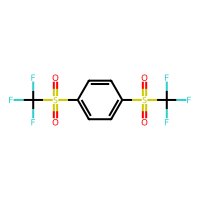
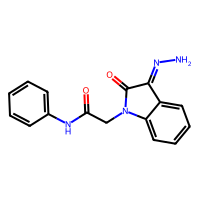
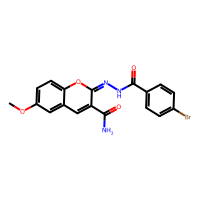
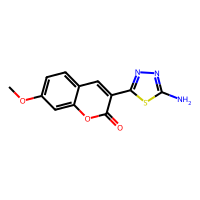
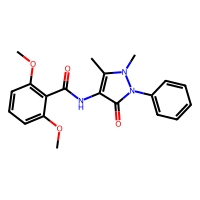
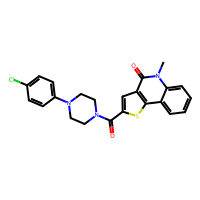
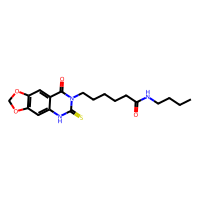
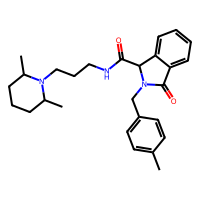
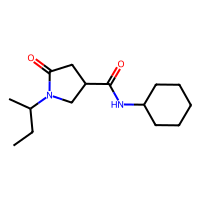
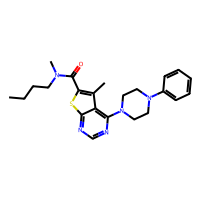

In [30]:
# read the SCAMS file and turn SCAMS into Molecule objects

scams = pd.read_csv('SCAMS.csv')
PandasTools.AddMoleculeColumnToFrame(scams, 'Smiles String','Molecule')
scams

In [31]:
# making of SDF file

PandasTools.WriteSDF(scams, 'scams_out.sdf', molColName='Molecule', properties=list(scams.columns))

In [32]:
# here was a step when SDF output was analysed in ChemSar
# exclude controversial structures acquired with ChemSar
scams.drop(labels=[254, 451, 470, 472, 474, 516, 97, 459], axis=0,  inplace=True, errors='raise')

In [33]:
#  remove unnesessary indexes
del scams['Unnamed: 0']

# change the index
scams_filt = scams.reset_index(drop=True, inplace=False)

In [34]:
# read the test data

test_set = pd.read_csv('test_DLS.csv') # прочитать тестовую выборку
PandasTools.AddMoleculeColumnToFrame(test_set, 'Smiles String','Molecule', includeFingerprints=False)

In [35]:
#  set values to 'int' type in the 'agg?' (target column)

scams_filt['agg?'] = scams_filt['agg?'].apply(lambda x: int(x))
test_set['agg?'] = test_set['agg?'].apply(lambda x: int(x))

In [36]:
scams_filt

,Smiles String,ID,agg?,Molecule
0,FC(F)(F)S(=O)(=O)c1ccc(cc1)S(=O)(=O)C(F)(F)F,0195-0009,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
1,N\N=C/1\C(=O)N(CC(=O)Nc2ccccc2)c3ccccc13,0784-0296,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
2,COc1ccc2O\C(=N\NC(=O)c3ccc(Br)cc3)\C(=Cc2c1)C(...,1612-0974,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
3,COc1ccc2C=C(C(=O)Oc2c1)c3nnc(N)s3,1711-1412,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
4,COc1cccc(OC)c1C(=O)NC2=C(C)N(C)N(C2=O)c3ccccc3,2134-0382,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
...,...,...,...,...
903,CN1C(=O)c2cc(sc2c3ccccc13)C(=O)N4CCN(CC4)c5ccc...,C498-0650,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
904,CCCCNC(=O)CCCCCN1C(=S)Nc2cc3OCOc3cc2C1=O,K284-5135,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
905,CC1CCCC(C)N1CCCNC(=O)C2N(Cc3ccc(C)cc3)C(=O)c4c...,K786-1357,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...
906,CCC(C)N1CC(CC1=O)C(=O)NC2CCCCC2,K786-9819,0,<rdkit.Chem.rdchem.Mol object at 0x000001D5B8E...


,ID,Smiles String,agg?,Molecule
0,5100051,O=C1NC(=S)NC(=O)C1=C/C=C/C=C/c1c(O)[nH]c(=S)[n...,0,
1,5105335,C/C(=N/NC(=O)NC1=CCCC=C1)c1cccc(-c2ccccc2)c1,1,
2,5110569,CC(C)CN(CC(C)C)CP(=S)(CN(CC(C)C)CC(C)C)CN(CC(C...,1,
3,5114506,C1CSC2(N1)C1CC3CC(C1)CC2C3.Cl,0,
4,5128360,Nc1ccc(Sc2ccc(Cc3ccc(Sc4ccc(N)cc4)cc3)cc2)cc1,1,
...,...,...,...,...
59,5469576,CC1(C)CC(NC2C3CC4CC(C3)CC2C4)CC(C)(C)N1.Cl.Cl,0,
60,5725697,C=CC1Oc2c(cc(C(C)(C)C)cc2C(C)(C)C)NC12C=C(C(C)...,1,
61,6258408,COc1ccc(-c2nc3cc(NC(=O)c4sc5ccccc5c4Cl)ccc3o2)cc1,1,
62,7724340,Ic1ccc(CSc2nnc[nH]2)cc1,1,

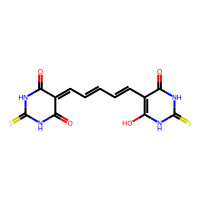
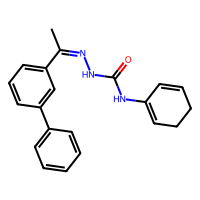
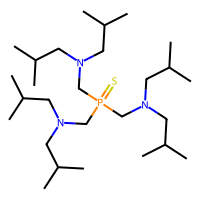
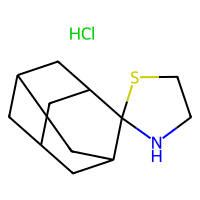
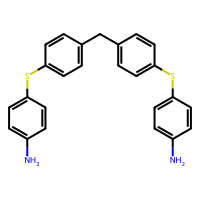
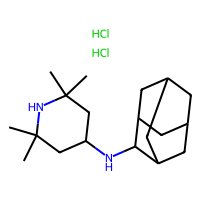
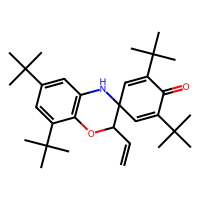
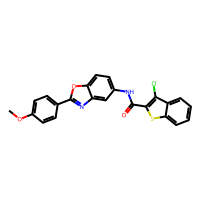
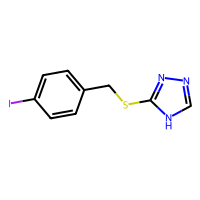
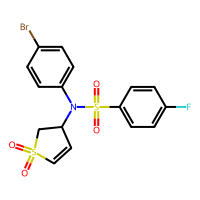

In [37]:
test_set

In [38]:
#  save result to sdf file
PandasTools.WriteSDF(test_set, 'test_set.sdf', molColName='Molecule', properties=list(test_set.columns))
PandasTools.WriteSDF(scams_filt, 'scams_filt.sdf', molColName='Molecule', properties=list(scams_filt.columns))

# scams_filt is actually train set
# test_set is a test set
# test_y = test_df['agg?']
# molecules are in the  'Smiles String' and 'Molecule' columns